In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from tueplots import bundles, figsizes
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import re
import os

In [2]:
plt.rcParams.update(bundles.neurips2021())

In [3]:
dat_src = r'../dat/bundesnetzagentur/pre_processed_data/prod_price_de_lu_2019_2021.csv'
fig_src = r'../doc/fig/'

In [4]:
combined = pd.read_csv(dat_src,
                       parse_dates=['time'])
combined = combined.set_index('time')
combined = combined.dropna()

In [5]:
def to_tex(text):
    """
    Helper function to prepare string for latex.
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

In [6]:
# define consistent colors for technologies
tech_colors = {
    'Biomass': '009632ff',
    'Nuclear': 'ff0000ff',
    'Brown Coal': '967d64ff',
    'Black Coal': '323232ff',
    'Natural Gas': 'fa964bff',
    'Pumped-Storage Hydro': '0096e1ff',
    'Wind': 'afc4a5ff',
    'Offshore Wind': '',
    'Onshore Wind': '',
    'Solar': 'ffcd64ff',
    'Hydropower': '0000c8ff',
    # 'Renewable': 'tab:olive',
    # 'Conventional': 'tab:brown'
}

# Regression

In [ ]:
cols = [('Solar', 'tab:orange'), ('Wind', 'tab:blue'), ('Solar & Wind', 'tab:green')]

fig, axs = plt.subplots(1, 3, figsize=(12,3), sharey=True) # figsize=(16,4), 

axs[0].set_ylabel('Price [€/MWh]')

# tmp = combined.sample(15000)

for i in range(0, len(axs)):
    col, color = cols[i]
    ax  = axs[i]
    
    X = combined[col].to_numpy().reshape(-1,1)
    y = combined['Price'].to_numpy()

    reg = LinearRegression()
    reg.fit(X, y)

    m = reg.coef_
    b = reg.intercept_
    
    ax.plot(X, y, 'o', color=color, ms=1, alpha=0.5)
    ax.plot(X, m*X + b, 'black')

    ax.set_xlabel(f'{to_tex(col)} Generation [MWh]')

plt.savefig(os.path.join(fig_src, 'solar_wind_regression.pdf'))

## Comparison of Renewable and Conventional

In [ ]:
renewable = ['Biomass', 
             'Hydropower', 
             'Offshore Wind', 
             'Onshore Wind', 
             'Solar', 
             'Other Renewables']
conventional = ['Nuclear', 
                'Brown Coal', 
                'Black Coal',
                'Natural Gas',
                'Other Conventional Sources']

con_ren                 = combined.copy() # .resample('D').mean()
con_ren['Conventional'] = con_ren.loc[:, conventional].sum(axis=1)
con_ren['Renewable']    = con_ren.loc[:, renewable].sum(axis=1)
con_ren                 = con_ren.filter(['Conventional', 'Renewable', 'Price'])
con_ren['Total']        = con_ren.loc[:, ('Conventional', 'Renewable')].sum(axis=1)

In [ ]:
X_con = con_ren['Conventional'].to_numpy()
X_ren = con_ren['Renewable'].to_numpy()
y     = con_ren['Price']

reg_con = LinearRegression()
reg_ren = LinearRegression()

reg_con.fit(X_con.reshape(-1,1), y)
reg_ren.fit(X_ren.reshape(-1,1), y)

m_con, b_con = reg_con.coef_, reg_con.intercept_
m_ren, b_ren = reg_ren.coef_, reg_ren.intercept_

In [ ]:
from tueplots import figsizes
# 2 rows
plt.rcParams.update(figsizes.neurips2021(nrows=2, ncols=1))
# 2 columns
# plt.rcParams.update(figsizes.neurips2021(nrows=1, ncols=2))

In [ ]:
# 2 rows
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
# 2 columns
# fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)

mincnt = 1
gridsize = 50

hb_ren = ax1.hexbin(X_ren,
           y,
           gridsize=gridsize,
           cmap='Greens',
           mincnt=mincnt,
           bins='log',
           vmin=mincnt,
           vmax=gridsize)
hb_con = ax2.hexbin(X_con,
           y,
           gridsize=gridsize,
           cmap='Purples',
           mincnt=mincnt,
           bins='log',
           vmin=mincnt,
           vmax=gridsize)

ax1.plot(X_ren, m_ren * X_ren + b_ren, 'tab:red', label='Regression Line (Renewable)', linewidth=2)
ax2.plot(X_con, m_con * X_con + b_con, 'tab:red', label='Regression Line (Conventional)', linewidth=2, linestyle='dotted')


fig.colorbar(hb_ren, ax=ax1, label='log10(N)')
fig.colorbar(hb_con, ax=ax2, label='log10(N)')

legend_elements = [Line2D([0], [0], marker='H', color='w', label='Hexbin (Renewable)',
                          markerfacecolor='tab:green', markersize=10),
                   Line2D([0], [0], color='tab:red', label='Regression Line (Renewable)'),
                   Line2D([0], [0], marker='H', color='w', label='Hexbin (Conventional)',
                          markerfacecolor='tab:purple', markersize=10),
                   Line2D([0], [0], color='tab:red', label='Regression Line (Conventional)', linestyle='dotted')]

# 2 rows
ax1.set_ylabel('Price [€/MWh]')
ax2.set_ylabel('Price [€/MWh]')
ax2.set_xlabel('Electricity Generation [MWh]')

# 2 columns
# ax1.set_xlabel('Electricity Generation [MWh]')
# ax2.set_xlabel('Electricity Generation [MWh]')
# ax1.set_ylabel('Price [€/MWh]')

ax1.grid()
ax2.grid()

fig.legend(loc='upper center', ncol=2, handles=legend_elements)
plt.savefig(os.path.join(fig_src, 'ren_vs_con_regression_separate.pdf'))
plt.show()

In [ ]:
fig, ax = plt.subplots()

mincnt = 1
gridsize = 50

hb_ren = plt.hexbin(X_ren,
                    y,
                    gridsize=gridsize,
                    cmap='Greens',
                    mincnt=mincnt,
                    bins='log',
                    vmin=mincnt,
                    vmax=gridsize)
hb_con = plt.hexbin(X_con,
                    y,
                    gridsize=gridsize,
                    cmap='Purples',
                    mincnt=mincnt,
                    bins='log',
                    vmin=mincnt,
                    vmax=gridsize)

plt.plot(X_ren, m_ren * X_ren + b_ren, 'tab:red', label='Regression Line (Renewable)', linewidth=2)
plt.plot(X_con, m_con * X_con + b_con, 'tab:red', label='Regression Line (Conventional)', linewidth=2, linestyle='dotted')

plt.xlabel('Electricity Generation [MWh]')
plt.ylabel('Price [€/MWh]')

# fig.colorbar(hb_ren)
# fig.colorbar(hb_con, label='log10(N)')

legend_elements = [Line2D([0], [0], marker='H', color='w', label='Hexbin (Renewable)',
                          markerfacecolor='tab:green', markersize=10),
                   Line2D([0], [0], color='tab:red', label='Regression Line (Renewable)'),
                   Line2D([0], [0], marker='H', color='w', label='Hexbin (Conventional)',
                          markerfacecolor='tab:purple', markersize=10),
                   Line2D([0], [0], color='tab:red', label='Regression Line (Conventional)', linestyle='dotted')]

plt.legend(loc='upper right', ncol=2, handles=legend_elements)
plt.savefig(os.path.join(fig_src, 'ren_vs_con_regression.pdf'))
plt.show()

# Pumped-Storage Hydro

In [ ]:
X = combined['Pumped-Storage Hydro'].to_numpy()
y = combined['Price'].to_numpy()

reg = LinearRegression()
reg.fit(X.reshape(-1,1), y)

m = reg.coef_
b = reg.intercept_

fig = plt.figure()

hb = plt.hexbin(X, y, gridsize=50, bins='log', cmap='Blues', mincnt=1, vmin=1, vmax=50)
plt.plot(X, m*X + b, 'tab:red', linewidth=2, label='Regression Line')

# fig.colorbar(hb, label='log10(N)')

plt.xlabel('Pumped-Storage Hydro Generation [MWh]')
plt.ylabel('Price [€/MWh]')

# plt.legend()

plt.savefig(os.path.join(fig_src, 'pumped_hydro_regression.pdf'))

# Quarterly Technology Mix with price

In [ ]:
quarterly       = combined.resample('3M').mean()
quarterly.index = pd.to_datetime(quarterly.index.date)
quarterly       = quarterly.loc[:'2021']
quarterly       = quarterly.rename(columns={'Other Conventional Sources': 'Other Conventionals'})

price = quarterly['Price']
quarterly = quarterly.drop(columns=['Price', 'Solar & Wind', 'Wind'])

width = 40
columns = list(quarterly)

fig, ax = plt.subplots() # figsize=(9, 7)
ax2 = ax.twinx()

for i, col in enumerate(columns):
    ax.bar(quarterly.index, quarterly[col], width=width, bottom=quarterly[columns[0:i]].sum(axis=1))

ax2.plot(price,
         color='k',
         linewidth=2, 
         marker='o')

ax.set_xlabel('Quarter')

ax.set_ylabel('Electricity Generation [MWh]')
ax2.set_ylabel('Price [€/MWh]')

ax.legend(list(quarterly), ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.22))
ax2.legend(['Price'], loc='upper center')

x_labels = ['2019 Q1', '2019 Q2', '2019 Q3', '2019 Q4',
           '2020 Q1', '2020 Q2', '2020 Q3', '2020 Q4',
           '2021 Q1', '2021 Q2', '2021 Q3', '2021 Q4']

plt.xticks(quarterly.index)
ax.set_xticklabels(x_labels)

for tick in ax.xaxis.get_major_ticks()[::2]:
    tick.set_pad(15)

# plt.tight_layout()

plt.savefig(os.path.join(fig_src, 'quarterly_technology_mix_with_price.pdf'))
plt.show()

# Example Day

In [17]:
plt.rcParams.update(figsizes.neurips2021(height_to_width_ratio=0.85))
# plt.rcParams.update(figsizes.neurips2021())

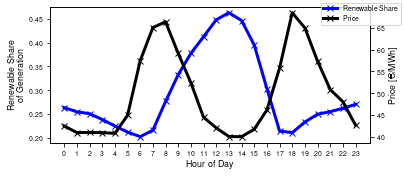

In [18]:
# example day
df = combined.copy()

renewable_cols = ['Biomass', 
                  'Hydropower', 
                  'Offshore Wind', 
                  'Onshore Wind', 
                  'Solar', 
                  'Other Renewables']

non_renewable_cols = ['Nuclear', 
                      'Brown Coal', 
                      'Black Coal',
                      'Natural Gas',
                      'Other Conventional Sources']

df['Total renewable'] = df[renewable_cols].sum(axis=1)
df['Total non-renewable'] = df[non_renewable_cols].sum(axis=1)
df['Total'] = df[['Total renewable', 'Total non-renewable']].sum(axis=1)

df = df[['Total renewable', 'Total non-renewable', 'Total', 'Price']]
df['Percentage renewable'] = df['Total renewable'] / df['Total']
df['Percentage non-renewable'] = df['Total non-renewable'] / df['Total']

percentage_df = df[['Percentage renewable',
                    'Percentage non-renewable',
                    'Price']]

percentage_df = percentage_df.loc['01-03-2021']

X = percentage_df.index.hour

percentage_renewable = percentage_df['Percentage renewable'].to_numpy()
percentage_non_renewable = percentage_df['Percentage non-renewable'].to_numpy() 

width = 4

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.set_xlabel('Hour of Day')

ax.plot(percentage_df['Percentage renewable'],
       color='blue',
       linewidth=3,
       marker='x')

ax2.plot(percentage_df['Price'],
         color='k',
         linewidth=3, 
         marker='x')

fig.legend(['Renewable Share', 'Price'], loc='upper right')

ax.set_ylabel('Renewable Share\n of Generation')
ax2.set_ylabel('Price [€/MWh]')

x_labels = list(range(24))

plt.xticks(percentage_df.index)
ax.set_xticklabels(x_labels)

plt.savefig(os.path.join(fig_src, 'example_day.pdf'))

plt.show()